#  Eryk Wdowiak and Aren Carpenter
###  ROUGH DRAFT -- Module 2 Statistics Assignment
####  17 July 2020

## Case Background & Key Questions	

Flatiron Health Insurance (FHI) is a growing private healthcare insurance provider founded on the premise that using data and analytics can improve the health insurance industry by providing better care and offerings to its patients. Every year, the Center for Disease Control (CDC) conducts surveys to understand the latest demographic, health, and fitness trends. You have been tasked with analyzing the recently published results of his years’ survey and providing your recommendations back to the Chief Analytics Officer and Chief Marketing Officer. You have been assigned the task of taking a first look at the data and beginning to answer several key questions:
											 								
1)  How does health status, represented by average number of days with bad physical health in the past month (PHYSHLTH), differ by state? Also provide an indication of distribution using whatever statistics you find suitable.
 												 								
2)  Digging deeper into the data, what are some factors that impact health (i.e. demographics, behaviors, previous illness, etc.)?	
						 						
To get you started, the IT department formatted the data set into a tab delimited text file for only NY, NJ, and CT (FHI’s primary markets) called `case_study.csv`. Below you will find a list of steps/questions that you will need to take in your investigation. The first part of the notebook will be focused on cleaning up your data and visualizing it.  The second part of the data set will be focused on performing statistical tests to make statements with statistical significance.  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy import stats
import statsmodels.api as sm

/usr/lib/python3/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# pd.read_csv('case_study.csv')

In [2]:
#Load our dataframe account for the index columns
df = pd.read_csv('case_study.csv', index_col=0)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (171) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#print(list(df.columns))
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
49938,9.0,5.0,5172017,5,17,2017,1200.0,2017000001,2.017000e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
49939,9.0,2.0,2142017,2,14,2017,1200.0,2017000002,2.017000e+09,NaN,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0
49940,9.0,1.0,1292017,1,29,2017,1200.0,2017000003,2.017000e+09,NaN,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,NaN,NaN,2.0
49941,9.0,7.0,9112017,9,11,2017,1200.0,2017000004,2.017000e+09,NaN,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0
49942,9.0,5.0,7182017,7,18,2017,1200.0,2017000005,2.017000e+09,NaN,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0


In [4]:
# Quickly check to see the size of our DF, both rows and columns
df.shape

(34545, 358)

In [5]:
#df['PHYSHLTH'].value_counts()

## Subset your dataframe to only include the states in the tri-state area (NJ, CT, NY)

In [6]:
# your code here
tristate = df[df['_STATE'].isin([9,34,36])]
tristate['state'] = np.where(tristate['_STATE'] == 9,'Connecticut',
                             np.where(tristate['_STATE'] == 34,'New Jersey',
                                      np.where(tristate['_STATE'] == 36,'New York','ERROR')))
tristate['ones'] = np.ones(tristate.shape[0])

Now check to see how large our subset df.

In [7]:
# your code here
tristate.shape

(34545, 360)

**PHYSHLTH** is the column we are interested in for this analysis, so let's start to investigate the column. Since we have a data cookbook, a.k.a. data dictionary) we want to start there before looking at the code.

In [8]:
tristate['PHYSHLTH'].describe()

count    34545.000000
mean        60.213403
std         37.504566
min          1.000000
25%         15.000000
50%         88.000000
75%         88.000000
max         99.000000
Name: PHYSHLTH, dtype: float64

## 1. Handle the non-normal values

As you can see from the data dictionary, there are a number of responses that are coded with values that could throw off our descriptive statistics.  Let's clean up by mapping the responses to a more appropriate value, and handling any missing values.  

In [9]:
#your code here
tristate['PHYSHLTH'] = np.where(tristate['PHYSHLTH'] == 77, np.NaN,
                                np.where(tristate['PHYSHLTH'] == 99, np.NaN,
                                         np.where(tristate['PHYSHLTH'] == 88, 0, tristate['PHYSHLTH'])))

## 2. Generate the descriptive statistics

Now that our target variable is cleaned up lets calculate the descriptive statistics, generate a graph that quickly shows those statistics, and generate a graph shows the distribution of the data.

In [10]:
# descriptive statistics
tristate['PHYSHLTH'].describe()

count    33747.000000
mean         4.085341
std          8.513293
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         30.000000
Name: PHYSHLTH, dtype: float64

In [11]:
print('observations:      ' + str(len(tristate['PHYSHLTH'])))
print('obs. w/ physhlth:  ' + str(len(tristate['PHYSHLTH'][tristate['PHYSHLTH'].isna() == False])))
print('without physhlth:    ' + str(len(tristate['PHYSHLTH'][tristate['PHYSHLTH'].isna() == True])))

observations:      34545
obs. w/ physhlth:  33747
without physhlth:    798


In [12]:
physhlth = tristate['PHYSHLTH'][tristate['PHYSHLTH'].isna() == False]

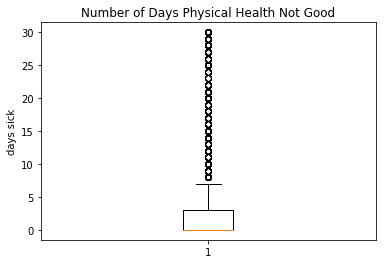

In [13]:
fig1, ax1 = plt.subplots()
ax1.set_title('Number of Days Physical Health Not Good')
ax1.set_ylabel('days sick')
ax1.boxplot(physhlth);

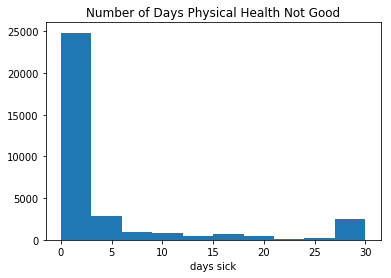

In [14]:
# graphic the distribution of data
fig1, ax1 = plt.subplots()
ax1.set_title('Number of Days Physical Health Not Good')
ax1.set_xlabel('days sick')
ax1.hist(physhlth);

## 3. Generate a graphic that compares the average number of sick days for each state. 

In [15]:
# code to calculate the average number of sick days by state
avgsick = tristate.groupby('state')['PHYSHLTH'].mean()
avgsick

state
Connecticut    3.688562
New Jersey     4.380957
New York       4.148030
Name: PHYSHLTH, dtype: float64

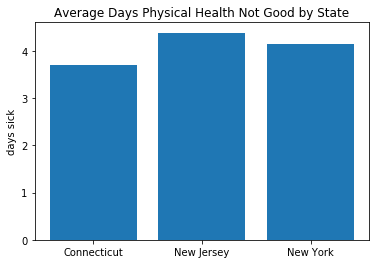

In [16]:
# code to graph those averages using matplotlib
xx_ticks = np.arange(3)
fig1, ax1 = plt.subplots()
ax1.set_title('Average Days Physical Health Not Good by State')
ax1.set_ylabel('days sick')
plt.bar(xx_ticks,avgsick);
plt.xticks(xx_ticks,avgsick.index);

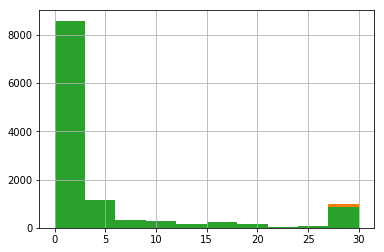

In [17]:
# graphic showing the histogram of data

##  group states
trisick = tristate[['state','PHYSHLTH']].groupby('state')
#trisick['PHYSHLTH'].head()
trisick['PHYSHLTH'].hist();

/home/eryk/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/eryk/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


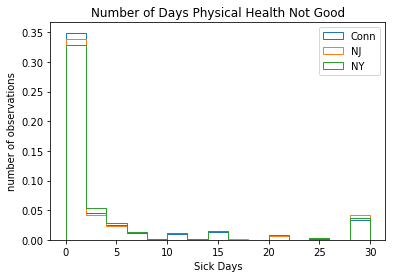

In [18]:
# graphic showing the histogram of data
##  Sean's code

fig, ax = plt.subplots()
# Plot a histogram of "Weight" for mens_rowing
ax.hist(tristate[tristate['_STATE']==9]['PHYSHLTH'], bins=15, density=True, histtype='step', label='Conn')
ax.hist(tristate[tristate['_STATE']==34]['PHYSHLTH'], bins=15, density=True,histtype='step', label='NJ')
ax.hist(tristate[tristate['_STATE']==36]['PHYSHLTH'], bins=15, density=True,histtype='step', label='NY')

# Set labels and title
ax.set_xlabel('Sick Days')
ax.set_ylabel('number of observations')
ax.set_title("Number of Days Physical Health Not Good")
ax.legend()

plt.show()

## 4. Turn the number of sick days into a classification of of chronically sick people.  

Chronically sick people account for a significant proportion of the costs for health insurers. If we can identify what leads people to be chronically sick, we can address them with specific treatments.



In [19]:
# code to create new column for chronically sick
tristate['chron'] = np.where(pd.isna(tristate['PHYSHLTH']), np.NaN,
                             np.where(tristate['PHYSHLTH']>12, 1, 0))

## 5. Create a graphic that compares the percentage of people labeled as 'sick' in each state. 

In [20]:
# code to calculate averages per state
avgchron = tristate.groupby('state')['chron'].mean()
avgchron

state
Connecticut    0.112744
New Jersey     0.136935
New York       0.126810
Name: chron, dtype: float64

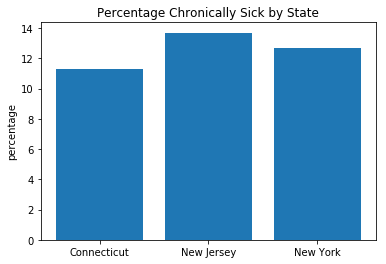

In [21]:
# code to graph those averages using matplotlib
xx_ticks = np.arange(3)
fig1, ax1 = plt.subplots()
ax1.set_title('Percentage Chronically Sick by State')
ax1.set_ylabel('percentage')
plt.bar(xx_ticks,100*avgchron);
plt.xticks(xx_ticks,avgchron.index);

## 6. Independent Variables (categorical)

Does smoking affect the number of days people feel physically ill? 
Let's take the column `SMOKDAY2` and start to prepare it so that we can see how it is possibly correlated to `PHYSHLTH`. When cleaning this data you will find that many respondents were not asked that question. read the codebook to understand why, and use that information when cleaning up your data. I.E, you will need to process two columns in order to create a new column of smokers.

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Generate a graphic that compares the physical health of the different groups of 'smokers'.

In [22]:
tristate['smoker'] = np.where(tristate['SMOKE100']==7,"don't know",
                              np.where(tristate['SMOKE100']==9,'refused',
                                       np.where(tristate['SMOKE100']==2,'non-smoker',
                                                np.where(tristate['SMOKDAY2']==7,"don't know",
                                                         np.where(tristate['SMOKDAY2']==9,'refused',
                                                                  np.where(tristate['SMOKDAY2']==3,'non-smoker',
                                                                           np.where(tristate['SMOKDAY2']==2,'some days',
                                                                                    np.where(tristate['SMOKDAY2']==1,'everyday',np.NaN))))))))                   

In [23]:
smokers = tristate.groupby('smoker').count()['state']
smokers = smokers[[3,1,5,0,4]] / smokers.sum()
smokers

smoker
non-smoker    0.833406
everyday      0.077464
some days     0.039687
don't know    0.005211
refused       0.002258
Name: state, dtype: float64

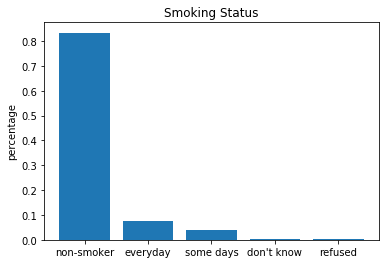

In [24]:
# code to graph those proportion of differen smoking groups using matplotlib
xx_ticks = np.arange(len(smokers.index))
fig1, ax1 = plt.subplots()
ax1.set_title('Smoking Status')
ax1.set_ylabel('percentage')
plt.bar(xx_ticks,smokers);
plt.xticks(xx_ticks,smokers.index);

In [25]:
smoker_states = tristate[['state','smoker']]
smoker_valid = [idx for idx, val in enumerate(smoker_states['smoker']) if val != 'nan']
smoker_states = smoker_states.iloc[smoker_valid]

smoker_states = smoker_states.groupby(['state','smoker'])['smoker'].count()
smoker_count = smoker_states.groupby('state').sum()
smoker_pct = smoker_states / smoker_count

#smoker_pct['Connecticut'][[2,4,1,0,3]]
#smoker_pct['New Jersey'][[2,4,1,0,3]]
smoker_pct['New York'][[2,4,1,0,3]]

smoker
non-smoker    0.859122
some days     0.046127
everyday      0.089157
don't know    0.002668
refused       0.002926
Name: smoker, dtype: float64

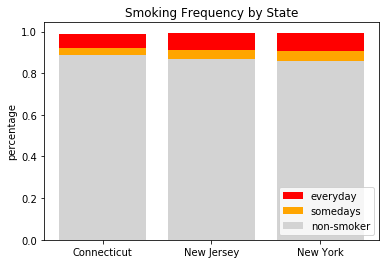

In [26]:
nonsmoker = [smoker_pct['Connecticut'][[2]][0],
             smoker_pct['New Jersey'][[2]][0],
             smoker_pct['New York'][[2]][0]]

some_days = [smoker_pct['Connecticut'][[4]][0],
             smoker_pct['New Jersey'][[4]][0],
             smoker_pct['New York'][[4]][0]]

every_day = [smoker_pct['Connecticut'][[1]][0],
             smoker_pct['New Jersey'][[1]][0],
             smoker_pct['New York'][[1]][0]]

smoke_unk = [smoker_pct['Connecticut'][[0]][0],  #+smoker_pct['Connecticut'][[3]][0],
             smoker_pct['New Jersey'][[0]][0],   #+smoker_pct['New Jersey'][[3]][0],
             smoker_pct['New York'][[0]][0]]     #+smoker_pct['New York'][[3]][0]]

none_some = list(np.array(nonsmoker) + np.array(some_days))
none_some_unk = list(np.array(nonsmoker) + np.array(some_days) + np.array(every_day))

xx_ticks = [0,1,2]
fig1, ax1 = plt.subplots()
ax1.set_title('Smoking Frequency by State')
ax1.set_ylabel('percentage')
pns = plt.bar(xx_ticks,nonsmoker,color='lightgray')
psd = plt.bar(xx_ticks,some_days,bottom=nonsmoker,color='orange')
ped = plt.bar(xx_ticks,every_day,bottom=none_some,color='red')
#puk = plt.bar(xx_ticks,every_day,bottom=none_some_unk)
plt.xticks(xx_ticks,['Connecticut','New Jersey','New York']);
#plt.legend((puk[0],ped[0],psd[0],pns[0]),("don't know",'everyday','somedays','non-smoker'))
plt.legend((ped[0],psd[0],pns[0]),('everyday','somedays','non-smoker'),loc='lower right')

del nonsmoker, some_days, every_day, none_some, none_some_unk, pns, psd, ped #, puk

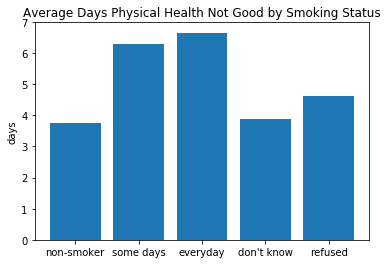

In [27]:
# code to graph these averages sick days for each category of smoking status
smoker_health = tristate[['smoker','PHYSHLTH']]
smoker_valid = [idx for idx, val in enumerate(smoker_health['smoker']) if val != 'nan']
smoker_health = smoker_health.iloc[smoker_valid]
health_valid = [idx for idx, val in enumerate(smoker_health['PHYSHLTH']) if val != 'nan']
smoker_health = smoker_health.iloc[health_valid]

smoker_physhlth = smoker_health.groupby('smoker').mean()
smoker_physhlth = smoker_physhlth['PHYSHLTH'][[2,4,1,0,3]]

xx_ticks = np.arange(len(smoker_physhlth.index))
fig1, ax1 = plt.subplots()
ax1.set_title('Average Days Physical Health Not Good by Smoking Status')
ax1.set_ylabel('days')
plt.bar(xx_ticks,list(smoker_physhlth))
plt.xticks(xx_ticks,smoker_physhlth.index);

## 7. Independent Variables (continuous):

Does the amount of days a person drinks affect the number of days they feel physically ill?
To investigate this, let's look at a continuous variable (ALCDAY5) and see how that might impact a person's health. 

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Calculate the correlation coefficient between `PHYSHLTH` and `ALCDAY5`.
5. Generate a graphic that shows the possible relationship between `PHYSHLTH` and `ALCDAY5`.

In [28]:
# code here to clean up the ALCDAY5 responses

##  Sean's code
alc_dict = {888:0, 777:np.nan, 999:np.nan}
tristate['alcohol'] = tristate['ALCDAY5'].replace(alc_dict)

##  Sean's code
# create a function called calc_monthly
def calc_monthly(x):
    if x>200:
        return x-200
    elif x>100:
        return min((x-100)*4.34524, 30)
    else:
        return x
    
tristate['alcohol']= tristate['alcohol'].apply(calc_monthly)

In [29]:
#descriptive statistics of cleaned data
tristate['alcohol'].describe()

count    32212.000000
mean         5.450859
std          8.404665
min          0.000000
25%          0.000000
50%          2.000000
75%          7.000000
max         30.000000
Name: alcohol, dtype: float64

/home/eryk/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/eryk/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


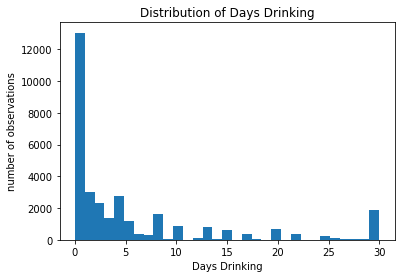

In [30]:
# graphic showing the histogram of data
##  Sean's code
fig, ax = plt.subplots()
ax.hist(tristate['alcohol'], bins=31)
ax.set_xlabel('Days Drinking')
ax.set_ylabel('number of observations')
ax.set_title("Distribution of Days Drinking")
plt.show()

In [31]:
# code to calculate averages per state
##  Sean's code
alcohol_state = tristate.groupby('_STATE')['alcohol'].mean().values
tristate.groupby('_STATE')['alcohol'].mean()

_STATE
9.0     6.166984
34.0    5.031192
36.0    5.233724
Name: alcohol, dtype: float64

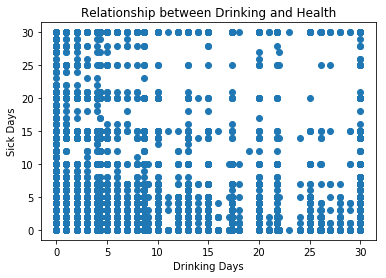

In [32]:
##  Sean's code
fig, ax = plt.subplots()

# Add data: "height", "weight" as x-y, index as color
ax.scatter(tristate["alcohol"], tristate["PHYSHLTH"])
ax.set_xlabel("Drinking Days")
ax.set_ylabel("Sick Days")
ax.set_title('Relationship between Drinking and Health')
plt.show()

In [33]:
# Code to calculate correlation of between number of dirnks of number of days physically ill
##  Sean's code
tristate[['PHYSHLTH', 'alcohol']].corr()['PHYSHLTH']

PHYSHLTH    1.000000
alcohol    -0.091154
Name: PHYSHLTH, dtype: float64

## 8. Statistical Inference


- Create a 95% confidence interval for the population mean of physically ill days.

-  Create a 95% confidence interval for the true proportion of chronically sick people.

## 9. Hypothesis Tests 

**For the follwing questions that require hypothesis tests, you must complete the following:**

*1. Write down the null and alternative hypothesis you are testing.* 

*2. Select the appropriate test and calculate the test statistic and P-values.*

*3. Determine the critical value for the 95% confidence interval.*

*4. Evaluate the test statistic agains the critical value.*

*5. Determine if you reject or fail to reject the null hypothesis and write a sentence explaining the results of your hypothesis test.*  

### The following questions are regarding the `PHYSHLTH` variable. 
- What is the probability of getting this sample mean for days physically ill, if the population mean is 4?
- Is there a statistically significant difference between men and women in the number of days a person feels phsyically ill?
- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states. 


In [34]:
##  estimate of the mean and std. error of our estimate
mx = tristate['PHYSHLTH'].mean()
sd = tristate['PHYSHLTH'].std()
nn = len(tristate['PHYSHLTH'])
se = sd/np.sqrt(nn)

##  calculate test statistics
mu = 4
tstat = (mx - mu)/se
pval = 1 - stats.t.cdf(x=tstat,df=nn-1)

##  calculate probability
print('mean:     '  + str("{:.4f}".format(mx)))
print('std err:  '  + str("{:.4f}".format(se)))
print('t-stat:   '  + str("{:.4f}".format(tstat)) + '  (H0:  mu = '+ str(mu) +')')
print('p value:  '  + str("{:.4f}".format(pval)))
print('num obs:   ' + str(nn) + '  (DF = '+ str(nn-1) +')')

del mx, sd, nn, se, mu, tstat, pval

mean:     4.0853
std err:  0.0458
t-stat:   1.8632  (H0:  mu = 4)
p value:  0.0312
num obs:   34545  (DF = 34544)


### The following questions are regarding the  `CHRONIC` variable.
- What is the probability of drawing this sample proportion if chronically true population proportion is 0.10?
- Is there a statistically significant difference in the percentage of men and women who are chronically sick?
- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states.

In [3]:
##  estimate of the mean and std. error of our estimate
ph = tristate['chron'].mean()
nn = len(tristate['chron'])
se = np.sqrt(ph*(1-ph)/nn)

##  calculate test statistics
pn = 0.10
zstat = (ph - pn)/se
pval = 1 - stats.norm.cdf(x=zstat)

##  calculate probability
print('est prob:  '  + str("{:.4f}".format(ph)))
print('std err:   '  + str("{:.4f}".format(se)))
print('z-stat:   '   + str("{:.4f}".format(zstat)) + '  (H0:  p = '+ str("{:.2f}".format(pn))+')')
print('p value:   '  + str("{:.4f}".format(pval)))
print('num obs:    ' + str(nn))

del ph, nn, se, pn, zstat, pval

NameError: name 'tristate' is not defined

# 10. Independent Investigation

Now that you have invesitgated physical health and chronic sickness and their relationships with states and gender, you will conduct a similar investigation with variables of your choosing. 

Select a continuous dependent varaible and a binary dependent variable that you would like to investigate. Then select a categorical independent variable with at least 3 groups and for which you will test to see if the response to the independent variable affects outcomes of the dependent variable.

For your continuous dependent variable perform the following:
  - Determine the sample mean and sample standard deviation
  - Create a confidence interval for a population mean.
  - Perform a two-sample test of means for gender.
  - Perform a one-way ANOVA using your categorical independent variable.

Select/create a binary variable from the survey questions as you dependent variable and perform the following:
  - Create a confidence interval for a population proportion.
  - Perform a two proportions z-test using gender.
  - Perform a Chi-Square test using your categorical independent variable.

###  M. Grossman (1976). "The Correlation between Health and Schooling"

In [36]:
##  relationship between health and education
edu_dict = {1:'did not finish',
            2:'high school grad',
            3:'some college',
            4:'college grad',
            9:np.nan}
tristate['education'] = tristate['_EDUCAG'].replace(edu_dict)
del edu_dict

hlthedu = tristate[['education','PHYSHLTH']].dropna()
#hlthedu.shape

In [37]:
##  let's create a table and take a closer look
hlthedu_table = hlthedu.groupby('education').mean()['PHYSHLTH'][[1,2,3,0]]
hlthedu_table

education
did not finish      7.017364
high school grad    5.124061
some college        4.650706
college grad        2.805341
Name: PHYSHLTH, dtype: float64

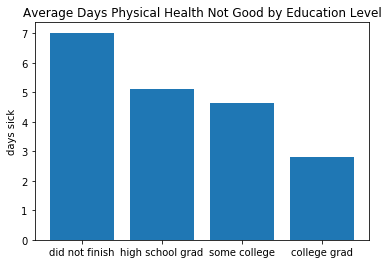

In [38]:
##  now plot relationship between education and health
xx_ticks = np.arange(len(hlthedu_table.index))
fig1, ax1 = plt.subplots()
ax1.set_title('Average Days Physical Health Not Good by Education Level')
ax1.set_ylabel('days sick')
plt.bar(xx_ticks,list(hlthedu_table))
plt.xticks(xx_ticks,hlthedu_table.index);

In [1]:
##  run an ANOVA test
hlthedu_ftest = stats.f_oneway(
    hlthedu['PHYSHLTH'][hlthedu['education'] == 'did not finish'],
    hlthedu['PHYSHLTH'][hlthedu['education'] == 'high school grad'],
    hlthedu['PHYSHLTH'][hlthedu['education'] == 'some college'],
    hlthedu['PHYSHLTH'][hlthedu['education'] == 'college grad'])

##  print test results
print('ANOVA test')
print('Null Hypothesis:  Number of Days Sick does not depend on Education')
print('F-stat:   ' + str("{:.4f}".format(hlthedu_ftest.statistic)))
print('p value:    ' + str("{:.4f}".format(hlthedu_ftest.pvalue)))
print('reject the null hypothesis')

NameError: name 'stats' is not defined

### relationship between smoking and education

In [40]:
##  isolate the variables
smokedu = tristate[['smoker','education']].dropna()
smokedu = smokedu.loc[(smokedu.smoker != 'nan')&(smokedu.smoker != "don't know")&(smokedu.smoker != 'refused')]
smokedu.shape

(32682, 2)

In [41]:
##  cross-tabulate
smokedu_crosstab = pd.crosstab(smokedu['education'],smokedu['smoker'])
smokedu_crosstab = smokedu_crosstab.reindex(['did not finish','high school grad','some college','college grad'])
smokedu_crosstab = smokedu_crosstab[['non-smoker','some days','everyday']]
smokedu_crosstab

smoker,non-smoker,some days,everyday
education,,,
did not finish,1749,152,333
high school grad,6445,412,1015
some college,6540,397,776
college grad,13918,403,542


In [42]:
##  get distributions by education level
smokedu_ctdist = smokedu_crosstab
smokedu_ctdist['sum'] = smokedu_ctdist.sum(axis=1)
smokedu_ctdist = smokedu_ctdist.iloc[:,0:3].div(smokedu_ctdist["sum"], axis=0)
print()
print('smoking decreases with educational attainment')
display(round(smokedu_ctdist,3))

##  clean up
del smokedu_ctdist
smokedu_crosstab = smokedu_crosstab.iloc[:,0:3]
#smokedu_crosstab


smoking decreases with educational attainment


smoker,non-smoker,some days,everyday
education,,,
did not finish,0.783,0.068,0.149
high school grad,0.819,0.052,0.129
some college,0.848,0.051,0.101
college grad,0.936,0.027,0.036


In [43]:
##  calculate the Chi-squared statistic and critical value
chi2stat, pvalue, degfree, expected = stats.chi2_contingency(smokedu_crosstab)
ci_level = 0.95
cvalue = stats.chi2.ppf(ci_level, degfree)

##  print test results
print('Chi-Squared test')
print('Null Hypothesis:  Smoking Status does not depend on Education')
print('Chi2-stat:  ' + str("{:.4f}".format(chi2stat)))
print('p value:       ' + str("{:.4f}".format(pvalue)))
print('reject the null hypothesis')

del chi2stat, pvalue, degfree, ci_level, cvalue ##, expected

Chi-Squared test
Null Hypothesis:  Smoking Status does not depend on Education
Chi2-stat:  1018.4375
p value:       0.0000
reject the null hypothesis


In [44]:
##  take the difference between the two tables
##  shows the relationship between education and smoking status
#obs_expect = smokedu_crosstab - expected
#round(obs_expect,1)